In [1]:
import numpy as np
import sklearn.gaussian_process as gp
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from scipy.stats import norm

from util.defs import *
from bayesian_optimizers.gpr_optimizer import GPROptimizer
from acquisition.acquisition_functions import ProbabilityOfImprovement
from acquisition.acquisition_optimizers import RandomAcquisitionOpt
sns.set_style("darkgrid")

In [2]:
rand = RandomState(seed=54321)

# Define functions

In [3]:
def objective(X, noise=0.1):
    noise = rand.normal(loc=0, scale=noise, size=X.shape)
    # want to do a minimization, so negate & translate up by 1.5
    return -(X**2 * np.sin(5 * np.pi * X)**6) + 1.5 + noise


def plot_real_sample_vs_surrogate_surface(X, y, model):
    _, ax = plt.subplots()
    
    X_samp = np.arange(0, 1, 0.001)[:, np.newaxis]
    y_samp = model.predict(X_samp)
    sns.scatterplot(X[:, 0], y[:, 0], ax=ax)
    sns.lineplot(X_samp[:, 0], y_samp[:, 0], ax=ax, color="black")
    
    return ax


# Define the GPR that will be used in the optimizer

In [4]:
kernel = gp.kernels.RBF()
# Defining the scale parameter here is cheating a bit (since used the same value when generating the data)
gpr = gp.GaussianProcessRegressor(kernel, 
                                  alpha=np.abs(rand.normal(scale=.1)),
                                  n_restarts_optimizer=10, 
                                  random_state=rand)

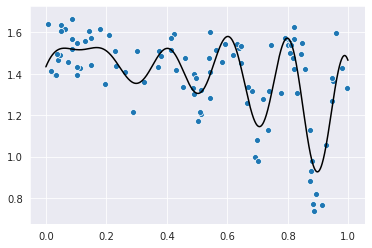

In [5]:
# take a random sample of X values
X = rand.random(100)[:, np.newaxis]
# plug the random sample into the objective
y = objective(X)

gpr.fit(X, y)
ax = plot_real_sample_vs_surrogate_surface(X, y, gpr)
plt.show()

# Select acquisition function, acquisition function optimizer, and define GPR optimizer

In [6]:
bounds = [(0.0, 1.0)]
p_types = [ParamType.Cont]

acquisition = ProbabilityOfImprovement(epsilon=1e-9)
opt_acquisition = RandomAcquisitionOpt(gpr, acquisition, rand)
gpr_opt = GPROptimizer(gpr, X, y, opt_acquisition, objective, bounds, p_types, fit=True)

# Perform Bayesian optimization

In [7]:
arg_mn = gpr_opt.optimize(100)

Best results (found by GP model): x = [0.89952372], y = [0.53223736]


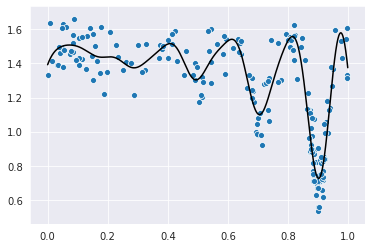

In [8]:
plot_real_sample_vs_surrogate_surface(gpr_opt.X, gpr_opt.y, gpr_opt.gpr)
print(f"Best results (found by GP model): x = {gpr_opt.X[arg_mn]}, y = {gpr_opt.y[arg_mn]}")